In [1]:
import numpy as np
import pandas as pd
import os
from bambi import Model

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from plotting_functions import plot_correlation, cm2inch, show_img
from pymc3 import plot_posterior

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load parameter recovery results:
recovery_dir = os.path.join('results', 'parameter_recovery')
files = [file for file in os.listdir(recovery_dir)
         if file.endswith('.csv')]

results = []

parameters = ['v', 'gamma', 's', 'tau']

dataset = np.array(39 * ['krajbich2010'] + 30 * ['krajbich2011'] + 24 * ['folke2016'] + 25 * ['tavares2017'])

for file in files:
    _, _, subject, _, _ = file.split('_')
    subject = int(subject)
    result = pd.read_csv(os.path.join(recovery_dir, file), index_col=0)
    results.append(pd.DataFrame(dict(subject=np.ones(len(parameters)).astype(int) * subject,
                                     dataset=[dataset[subject]] * len(parameters),
                                     parameter=parameters,
                                     generating=result.loc[[parameter + '__0_0'
                                                            for parameter in parameters],
                                                           'generating'],
                                     recovered=result.loc[[parameter + '__0_0'
                                                           for parameter in parameters],
                                                          'MAP'])))
results = pd.concat(results).sort_values(['subject', 'parameter']).reset_index(drop=True)

In [3]:
results.head()

,subject,dataset,parameter,generating,recovered
0,0,krajbich2010,gamma,0.790000,0.980000
1,0,krajbich2010,s,0.010750,0.010854
2,0,krajbich2010,tau,0.490000,0.810000
3,0,krajbich2010,v,0.000084,0.000074
4,1,krajbich2010,gamma,-0.130000,0.280000


In [4]:
def figure_si_6(results, figsize=cm2inch(18, 5), colors=None, fontsize=7, plot_legend=False):

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']

    if colors is None:
        colors = np.array(['C{}'.format(i)
                           for i in range(results['dataset'].unique().size)])

    parameters = ['v', 'gamma', 's', 'tau']
    parameter_labels = [r'$v$', r'$\gamma$', r'$\sigma$', r'$\tau$']
    parameter_limits = [(0, 0.000225), (-1.5, 1.25), (0, 0.0225), (0, 5.5)]
    parameter_ticks = [[0, 0.0001, 0.0002], [-1, 0, 1], [0, 0.01, 0.02], [0, 1, 2, 3, 4, 5]]
    fig, axs = plt.subplots(1, 4, figsize=figsize)

    for p, (parameter, label, limits, ticks) in enumerate(zip(parameters, 
                                                              parameter_labels,
                                                              parameter_limits,
                                                              parameter_ticks)):
        results_parameter = results.loc[results['parameter'] == parameter]
        color_idx = pd.Categorical(results_parameter['dataset'], categories=datasets, ordered=True).codes.astype(int)
        axs[p].scatter(results_parameter['generating'],
                       results_parameter['recovered'],
                       marker='o',
                       color='none',
                       edgecolor=colors[color_idx],
                       linewidth=0.5,
                       s=30)
        axs[p].scatter(results_parameter['generating'],
                       results_parameter['recovered'],
                       marker='o',
                       color=colors[color_idx],
                       alpha=0.5,
                       linewidth=0,
                       s=30)
        axs[p].set_xlim(limits)
        axs[p].set_ylim(limits)
        axs[p].set_title(label, fontsize=fontsize)
        axs[p].set_xlabel('Generating', fontsize=fontsize)
        axs[p].set_ylabel('Recovered', fontsize=fontsize)
        axs[p].set_xticks(ticks)
        axs[p].set_yticks(ticks)
        axs[p].set_xticklabels(ticks, fontsize=fontsize)
        axs[p].set_yticklabels(ticks, fontsize=fontsize)

    if plot_legend:
        patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
                   for i in range(len(datasets))]
        axs[0].legend(patches,
                      ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                      loc='lower right',
                      handlelength=1, handleheight=1,
                      fontsize=5,
                      frameon=False)

    # Labels
    for label, ax in zip(list('abcd'), axs.ravel()):
        ax.text(-0.3, 1.1, label, transform=ax.transAxes,
                fontsize=fontsize, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Font sizes
        ax.tick_params(axis='both', labelsize=fontsize)

        # Plot diagonal
        ax.plot(ax.get_xlim(), ax.get_xlim(), color='black', alpha=1, linewidth=1, zorder=-1)
        
    fig.tight_layout()

    return fig, axs

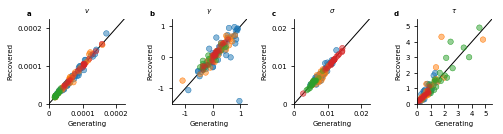

In [5]:
figure_si_6(results);
plt.savefig('results/figures/si_figure_6_parameter_recovery.png', dpi=330, bbox_inches='tight')
plt.savefig('results/figures/si_figure_6_parameter_recovery.pdf', dpi=330, bbox_inches='tight')
plt.show()

# Bias Analyses

In [6]:
df = results.melt(id_vars=['subject', 'dataset', 'parameter'], value_vars=['generating', 'recovered'], var_name='type').sort_values(['subject', 'parameter']).reset_index(drop=True)
df['is_recovered'] = (df['type'] == 'recovered').astype(float)
df.head()

,subject,dataset,parameter,type,value,is_recovered
0,0,krajbich2010,gamma,generating,0.790000,0.0
1,0,krajbich2010,gamma,recovered,0.980000,1.0
2,0,krajbich2010,s,generating,0.010750,0.0
3,0,krajbich2010,s,recovered,0.010854,1.0
4,0,krajbich2010,tau,generating,0.490000,0.0


v


/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 8,825.4: 100%|██████████| 50000/50000 [00:40<00:00, 1227.10it/s]   
Finished [100%]: Average Loss = 8,768.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sd, is_recovered|dataset_offset, is_recovered|dataset_sd, 1|dataset_offset, 1|dataset_sd, is_recovered, Intercept]
Sampling 2 chains: 100%|██████████| 61000/61000 [42:04<00:00, 12.55draws/s]
The number of effective samples is smaller than 25% for some parameters.


                                            mean        sd  hpd0.95_lower  \
is_recovered|dataset_sd             6.951740e-06  0.000009   4.149151e-11   
is_recovered|dataset[folke2016]    -4.179241e-07  0.000007  -1.428727e-05   
is_recovered|dataset[krajbich2010] -2.107000e-07  0.000007  -1.333805e-05   
is_recovered|dataset[krajbich2011]  1.790401e-07  0.000007  -1.327700e-05   
is_recovered|dataset[tavares2017]   4.142537e-07  0.000007  -1.297363e-05   
1|dataset[folke2016]               -3.744099e-05  0.000015  -6.945447e-05   
1|dataset[krajbich2010]             1.270730e-05  0.000015  -1.855124e-05   
1|dataset[krajbich2011]             2.604384e-06  0.000015  -2.838402e-05   
1|dataset[tavares2017]              2.132381e-05  0.000015  -1.064517e-05   
is_recovered                       -4.258305e-09  0.000007  -1.208974e-05   
Intercept                           6.499155e-05  0.000015   3.434362e-05   
value_sd                            3.022045e-05  0.000001   2.750301e-05   

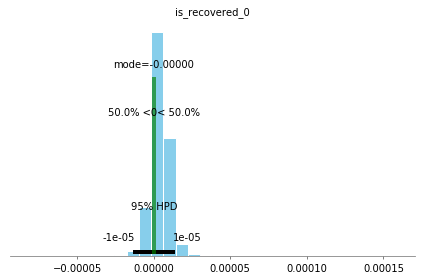

gamma


/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 135.3:  37%|███▋      | 18653/50000 [00:15<00:25, 1238.69it/s] 
Convergence achieved at 18700
Interrupted at 18,699 [37%]: Average Loss = 577.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sd, is_recovered|dataset_offset, is_recovered|dataset_sd, 1|dataset_offset, 1|dataset_sd, is_recovered, Intercept]
Sampling 2 chains: 100%|██████████| 61000/61000 [03:08<00:00, 323.82draws/s]
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There we

                                        mean        sd  hpd0.95_lower  \
is_recovered|dataset_sd             0.087479  0.098996       0.000001   
is_recovered|dataset[folke2016]    -0.007391  0.078848      -0.179695   
is_recovered|dataset[krajbich2010] -0.009652  0.075945      -0.184323   
is_recovered|dataset[krajbich2011]  0.007401  0.075575      -0.153483   
is_recovered|dataset[tavares2017]   0.006528  0.077864      -0.153656   
1|dataset[folke2016]               -0.099469  0.094485      -0.299020   
1|dataset[krajbich2010]             0.085934  0.090272      -0.082528   
1|dataset[krajbich2011]             0.034938  0.088481      -0.145946   
1|dataset[tavares2017]             -0.025622  0.088999      -0.209345   
is_recovered                       -0.033902  0.077722      -0.186047   
Intercept                           0.136625  0.084162      -0.045565   
value_sd                            0.389910  0.011266       0.368768   
1|dataset_sd                        0.137915  0.087

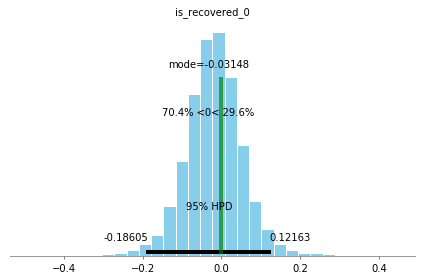

s


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -1,090.7:  91%|█████████▏| 45648/50000 [00:37<00:03, 1214.60it/s]  
Convergence achieved at 45700
Interrupted at 45,699 [91%]: Average Loss = 3.5883e+06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sd, is_recovered|dataset_offset, is_recovered|dataset_sd, 1|dataset_offset, 1|dataset_sd, is_recovered, Intercept]
Sampling 2 chains: 100%|██████████| 61000/61000 [14:00<00:00, 72.60draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.890592701128019, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887196398793421, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


                                        mean        sd  hpd0.95_lower  \
is_recovered|dataset_sd             0.000413  0.000507   1.175473e-08   
is_recovered|dataset[folke2016]     0.000017  0.000392  -7.983618e-04   
is_recovered|dataset[krajbich2010]  0.000021  0.000379  -7.571990e-04   
is_recovered|dataset[krajbich2011] -0.000074  0.000390  -9.202820e-04   
is_recovered|dataset[tavares2017]   0.000037  0.000392  -7.435034e-04   
1|dataset[folke2016]               -0.002512  0.001158  -4.813972e-03   
1|dataset[krajbich2010]             0.000235  0.001150  -2.105002e-03   
1|dataset[krajbich2011]            -0.000627  0.001154  -2.960165e-03   
1|dataset[tavares2017]              0.002898  0.001158   5.292771e-04   
is_recovered                       -0.000285  0.000384  -9.891638e-04   
Intercept                           0.008369  0.001141   6.124589e-03   
value_sd                            0.001721  0.000080   1.567019e-03   
1|dataset_sd                        0.002333  0.000

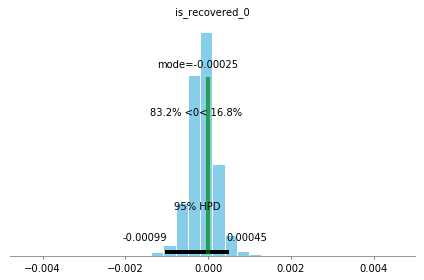

tau


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 286.87:  29%|██▉       | 14571/50000 [00:11<00:28, 1260.59it/s]
Convergence achieved at 14600
Interrupted at 14,599 [29%]: Average Loss = 530.41
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sd, is_recovered|dataset_offset, is_recovered|dataset_sd, 1|dataset_offset, 1|dataset_sd, is_recovered, Intercept]
Sampling 2 chains: 100%|██████████| 61000/61000 [04:20<00:00, 233.95draws/s]
There were 337 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                                        mean        sd  hpd0.95_lower  \
is_recovered|dataset_sd             0.171427  0.191797       0.000004   
is_recovered|dataset[folke2016]     0.014241  0.155317      -0.303411   
is_recovered|dataset[krajbich2010]  0.000210  0.147585      -0.318546   
is_recovered|dataset[krajbich2011]  0.015668  0.150932      -0.313711   
is_recovered|dataset[tavares2017]  -0.030665  0.154272      -0.383646   
1|dataset[folke2016]                0.753607  0.349399       0.070554   
1|dataset[krajbich2010]            -0.329672  0.345228      -1.017057   
1|dataset[krajbich2011]             0.026229  0.346175      -0.685019   
1|dataset[tavares2017]             -0.413127  0.351035      -1.124929   
is_recovered                        0.045551  0.149053      -0.248105   
Intercept                           0.926238  0.340206       0.255271   
value_sd                            0.743730  0.034783       0.676146   
1|dataset_sd                        0.637339  0.249

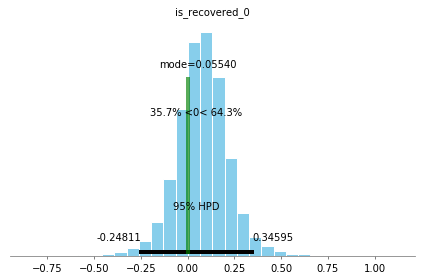

In [7]:
bias_analysis_results = {}
models = {}
n_samples = 30000
parameters = ['v', 'gamma', 's', 'tau']
for parameter in parameters:
    print(parameter)
    result_path = 'results/mixed_effects_models/si6_parameter_recovery_{}_bias_analysis.csv'.format(parameter)
    plot_path = 'results/mixed_effects_models/si6_parameter_recovery_{}_bias_analysis.png'.format(parameter)
    if (not os.path.isfile(result_path)) or (not os.path.isfile(plot_path)):
        model = Model(df.loc[df['parameter'] == parameter].reset_index(drop=True).copy())
        models[parameter] = model
        result_fit = model.fit('value ~ is_recovered',
                           random=['is_recovered|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
        # save summary
        result = result_fit.summary(ranefs=True)
        print(result)
        result.to_csv(result_path)
        # save posteriorplot
        plot_posterior(model.backend.trace,
                       varnames=['is_recovered'],
                       round_to=5,
                       point_estimate='mode',
                       ref_val=0)
        plt.savefig(plot_path, dpi=330)
        plt.show()
    else:
        print('Results loaded from: {}'.format(result_path))
        result = pd.read_csv(result_path)
        print(result)
        show_img(plot_path)
        
    # bias_analysis_results[parameter] = result 